In [110]:
# ---------------------------------------------------------------
# Simple plotting + record preview (no ipywidgets required)
# ---------------------------------------------------------------
import duckdb, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

# ── configuration ───────────────────────────────────────────────
DB_PATH     = Path("events.db")             # or os.getenv("DB_PATH")
START_TS_NS = None                          # e.g. 1_717_000_000_000_000_000
END_TS_NS   = None                          # e.g. 1_717_000_900_000_000_000

SHOW_COLS   = ["tps", "read_sec", "write_sec", "total_sec"]  # choose any subset
PRINT_ROWS  = 20                                              # rows to display

# ── helpers ────────────────────────────────────────────────────
def time_predicate(start_ns, end_ns):
    where, params = "", []
    if start_ns is not None:
        where += " AND ts >= ?"; params.append(start_ns)
    if end_ns is not None:
        where += " AND ts <= ?"; params.append(end_ns)
    return where, params

def get_rates(con, where, params):
    sql = f"""
    WITH
      tps AS    (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS tps
                 FROM txns   WHERE 1=1 {where} GROUP BY sec),
      reads AS  (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS read_sec
                 FROM diskio WHERE op='R' {where} GROUP BY sec),
      writes AS (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS write_sec
                 FROM diskio WHERE op='W' {where} GROUP BY sec),
      total AS  (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS total_sec
                 FROM diskio WHERE 1=1 {where} GROUP BY sec)
    SELECT * FROM tps
      FULL OUTER JOIN reads  USING (sec)
      FULL OUTER JOIN writes USING (sec)
      FULL OUTER JOIN total  USING (sec)
    ORDER BY sec;
    """
    return con.execute(sql, params).df().fillna(0)

def get_secidx(con, where, params):
    sql = f"""
    SELECT floor(ts/1e9) AS sec, container,
           SUM(h)*100 AS h, SUM(p)*100 AS p, SUM(f)*100 AS f
    FROM sec_index_hit_rate
    WHERE 1=1 {where}
    GROUP BY sec, container
    ORDER  BY sec, container;
    """
    return con.execute(sql, params).df()

def peek_table(con, name, where, params, n=20):
    return con.execute(f"SELECT * FROM {name} WHERE 1=1 {where} LIMIT {n}", params).df()

# ── main ───────────────────────────────────────────────────────
def plot_db(db_path, start_ts_ns=None, end_ts_ns=None, show_cols=SHOW_COLS):
    con = duckdb.connect(database=str(db_path), read_only=True)
    where, params = time_predicate(START_TS_NS, END_TS_NS)

    rates  = get_rates(con,  where, params)
    secidx = get_secidx(con, where, params)

    # >>>–––––––––––––– 1. make x-axis start at 0 –––––––––––––––––––>
    if not rates.empty or not secidx.empty:
        first_sec = min(
            [df["sec"].min() for df in (rates, secidx) if not df.empty]
        )
        print(f"First second: {first_sec}")
        rates["t"]   = rates["sec"]   - first_sec
        secidx["t"]  = secidx["sec"]  - first_sec
    else:
        raise ValueError("no rows returned – cannot compute relative time")
    # <<<–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––<

    # --- 1. Plot selected throughput / I/O series ------------------
    if not SHOW_COLS:
        raise ValueError("SHOW_COLS is empty—please list at least one column to plot.")

    fig1, ax1 = plt.subplots(figsize=(10,4))
    for col in SHOW_COLS:
        if col not in rates.columns:
            print(f"⚠️  Skipping unknown column '{col}'")
            continue
        ax1.plot(rates["t"], rates[col], label=col)
    ax1.set_xlabel("epoch-second"); ax1.set_ylabel("events / sec (scaled)")
    ax1.set_title("Throughput & I/O rates"); ax1.legend(); fig1.tight_layout()

    # --- 2. Plot sec_index_hit_rate (unchanged) --------------------
    fig2, ax2 = plt.subplots(figsize=(10,4))
    hit_rate_cols = [(6,"h"),(6,"f"),(6,"p"),(8,"h"),(8,"f"),(8,"p")]
    hit_rate_cols = [(6,"h"),(6,"f"),(6,"p")]
    for (cont, field) in hit_rate_cols:
        sub = secidx[secidx["container"] == cont]
        if field == "h" :
            label = f"c={cont},P(HIT), F(HIT)"
        elif field == "p" :
            label = f"c={cont},P(MISS)"
        elif field == "f" :
            label = f"c={cont},P(HIT), F(MISS)"
        ax2.plot(sub["t"], sub[field], label=label)
    ax2.set_xlabel("epoch-second"); ax2.set_ylabel("sum / sec")
    ax2.set_title("sec_index_hit_rate per container")
    ax2.set_ylim(bottom=0)
    ax2.legend(ncol=6); fig2.tight_layout()

    fig3, ax3 = plt.subplots(figsize=(10,4))
    hit_rate_cols = [(8,"h"),(8,"f"),(8,"p")]
    for (cont, field) in hit_rate_cols:
        sub = secidx[secidx["container"] == cont]
        if field == "h" :
            label = f"c={cont},P(HIT), F(HIT)"
        elif field == "p" :
            label = f"c={cont},P(MISS)"
        elif field == "f" :
            label = f"c={cont},P(HIT), F(MISS)"
        ax3.plot(sub["t"], sub[field], label=label)
    ax3.set_xlabel("epoch-second"); ax3.set_ylabel("sum / sec")
    ax3.set_title("sec_index_hit_rate per container")
    ax3.set_ylim(bottom=0)
    ax3.legend(ncol=6); fig3.tight_layout()

    plt.show()

def print_db(db_path, start_ts_ns=None, end_ts_ns=None, print_rows=PRINT_ROWS):
    con = duckdb.connect(database=str(db_path), read_only=True)
    where, params = time_predicate(start_ts_ns, start_ts_ns)

    print(f"\nShowing first {PRINT_ROWS} rows of each table:")
    for tbl in ["txns", "diskio", "sec_index_hit_rate"]:
        print(f"\n— {tbl} —")
        display(peek_table(con, tbl, where, params, PRINT_ROWS))


In [ ]:
import duckdb, matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.ticker import FuncFormatter

class EventDB:
    # ── construction ───────────────────────────────────────────
    def __init__(self, path, *, read_only=True):
        self.path = str(path)
        self.con  = duckdb.connect(self.path, read_only=read_only)

    # ── static helpers (pure functions) ─────────────────────────
    @staticmethod
    def _time_pred(start_ns, end_ns):
        where, params = "", []
        if start_ns is not None: where += " AND ts >= ?"; params.append(start_ns)
        if end_ns   is not None: where += " AND ts <= ?"; params.append(end_ns)
        return where, params

    @staticmethod
    def _align_time(*dfs):
        first = min(df["sec"].min() for df in dfs if not df.empty)
        for df in dfs: df["t"] = df["sec"] - first
        return first

    # ── duckdb query helpers ────────────────────────────────────
    def _rates_df(self, where, params):
        sql = f"""
        WITH
          tps AS    (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS tps
                     FROM txns   WHERE 1=1 {where} GROUP BY sec),
          reads AS  (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS read_sec
                     FROM diskio WHERE op='R' {where} GROUP BY sec),
          writes AS (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS write_sec
                     FROM diskio WHERE op='W' {where} GROUP BY sec),
          total AS  (SELECT floor(ts/1e9) AS sec, COUNT(*)*100 AS total_sec
                     FROM diskio WHERE 1=1 {where} GROUP BY sec)
        SELECT * FROM tps
          FULL OUTER JOIN reads  USING (sec)
          FULL OUTER JOIN writes USING (sec)
          FULL OUTER JOIN total  USING (sec)
        ORDER BY sec;"""
        return self.con.execute(sql, params).df().fillna(0)

    def _secidx_df(self, where, params):
        sql = f"""
        SELECT floor(ts/1e9) AS sec, container,
               SUM(h)*100 AS h, SUM(p)*100 AS p, SUM(f)*100 AS f
        FROM sec_index_hit_rate
        WHERE 1=1 {where}
        GROUP BY sec, container
        ORDER  BY sec, container;"""
        return self.con.execute(sql, params).df()

    # ── public graph-drawing API ────────────────────────────────
    def plot(self, *,                               #
             start_ts_ns=None, end_ts_ns=None,      # time window
             show_cols=("tps","read_sec","write_sec","total_sec"),
             containers=(6,8)):
        where, params = self._time_pred(start_ts_ns, end_ts_ns)
        rates  = self._rates_df(where, params)
        secidx = self._secidx_df(where, params)
        if rates.empty and secidx.empty:
            print("⚠️  no rows returned for that time window")
            return

        first = self._align_time(rates, secidx)
        print(f"[{self.path}] aligned at epoch-second {first}")

        # ── 1. throughput / I-O ────────────────────────────────
        fig1, ax1 = plt.subplots(figsize=(10,4))
        for col in show_cols:
            if col in rates.columns:
                ax1.plot(rates["t"], rates[col], label=col)
        ax1.set_xlabel("seconds since start")
        ax1.set_ylabel("Events / Sec")
        ax1.set_title("Throughput & I/O rates")
        ax1.legend()
        fig1.tight_layout()
        ax1.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

        # ── 2 & 3. sec_index_hit_rate ──────────────────────────
        for cont in containers:
            fig2, ax2 = plt.subplots(figsize=(10,4))
            for field in ("h","f","p"):
                sub = secidx[secidx["container"] == cont]
                if field == "h" :
                    label = f"P(HIT), F(HIT)"
                elif field == "f" :
                    label = f"P(HIT), F(MISS)"
                elif field == "p" :
                    label = f"P(MISS)"
                ax2.plot(sub["t"], sub[field], label=label)
            ax2.set_xlabel("seconds since start")
            ax2.set_ylabel("Rows Accessed / Sec")
            if cont == 6:
                title = "Customer Sec Index Hit Rate"
            elif cont == 8:
                title = "Order Sec Index Hit Rate"
            ax2.set_title(title)
            ax2.legend(ncol=3)
            fig2.tight_layout()

        plt.show()

    # ── public row-preview API ──────────────────────────────────
    def preview(self, *, start_ts_ns=None, end_ts_ns=None, rows=20):
        where, params = self._time_pred(start_ts_ns, end_ts_ns)
        for tbl in ("txns","diskio","sec_index_hit_rate"):
            print(f"\n— {tbl} (first {rows}) —")
            df = self.con.execute(
                f"SELECT * FROM {tbl} WHERE 1=1 {where} LIMIT {rows}", params
            ).df()
            display(df)

def thousands_formatter(x, pos):
    # Convert x to thousands and format as two digits (if desired)
    # This will force two-digit formatting for values less than 100.
    # For values over 99, it will print normally (e.g. 100K)
    if x == 0:
        return '0'
    return f'{int(x/1000):02d}K'

[events.db] aligned at epoch-second 1747496972.0


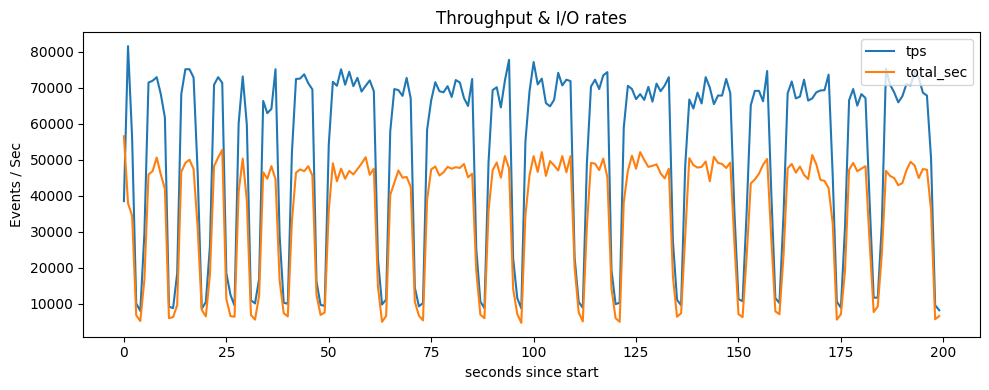

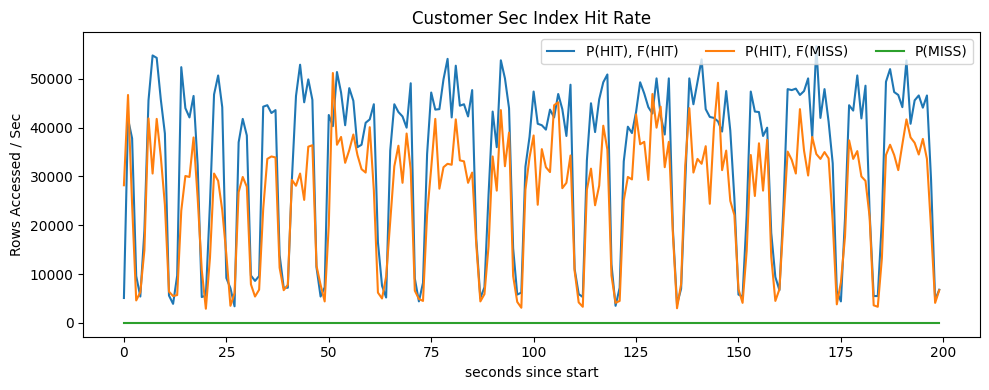

In [112]:
# one connection, many calls
db = EventDB("events.db")

# db.plot()                           # default everything
db.plot(show_cols=("tps","total_sec"), containers=(6,))   # custom view
# db.preview(rows=5)                  # peek at raw rows



[events2.db] aligned at epoch-second 1747502866.0


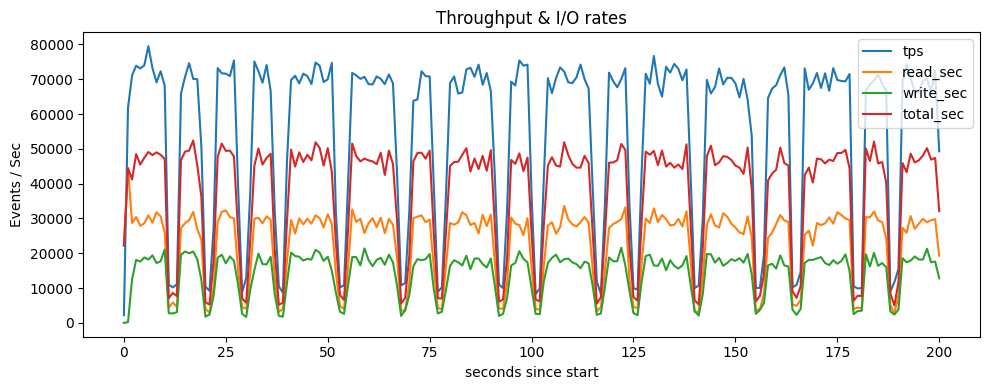

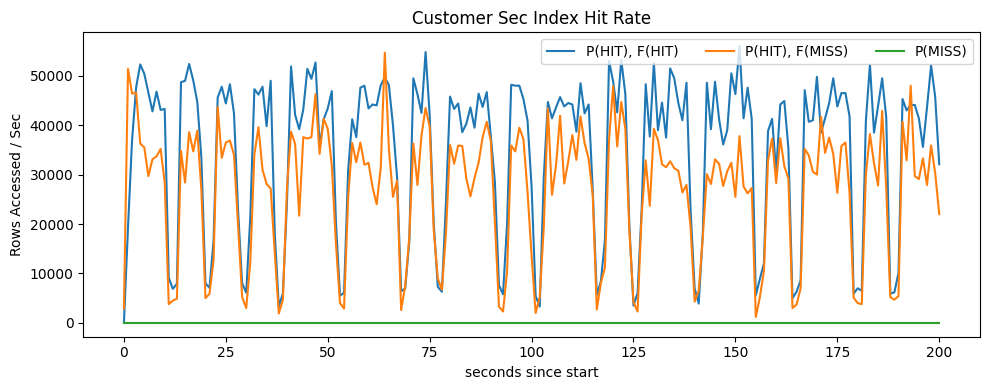

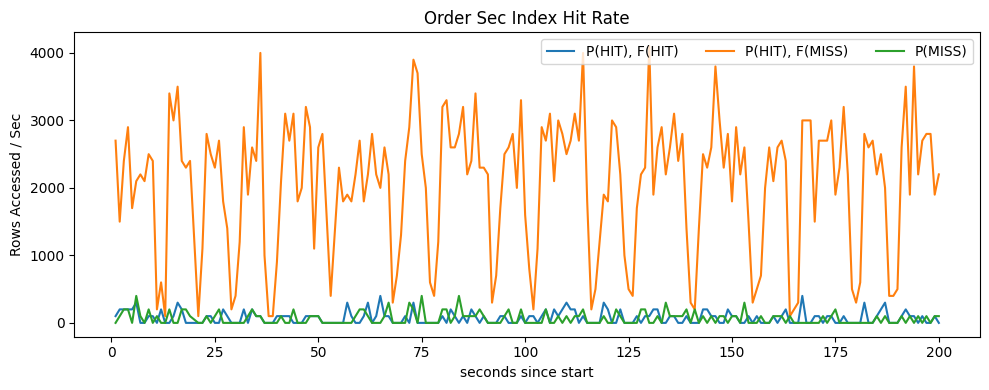

In [113]:
# open a *second* file without touching the first
other = EventDB("events2.db")
other.plot()                       # default everything
